<a href="https://colab.research.google.com/github/NahataiTep/DPDM65/blob/main/Triplet01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/CrimyTheBold/tripletloss/blob/master/02%20-%20tripletloss%20MNIST.ipynb

#1. Import Package

In [1]:
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.datasets import mnist

from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from tensorflow.keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model,normalize

from sklearn.metrics import roc_curve,roc_auc_score

#2. Import Dataset : MNIST
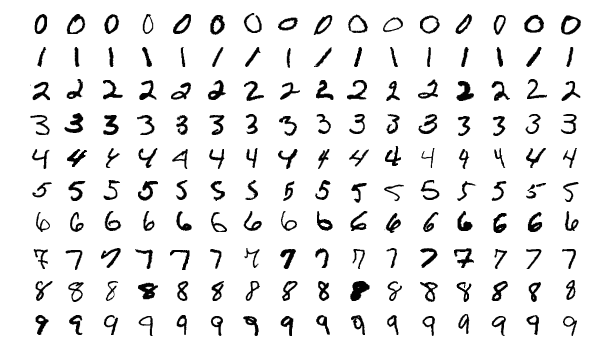

In [2]:
nb_classes = 10
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """
    (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = mnist.load_data()

    assert K.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)
        
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin

In [3]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='Greys')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

11490434/11490434 [==============================] - 0s 0us/step
Checking shapes for class 0 (train) :  (5923, 28, 28, 1)
Checking shapes for class 0 (test) :  (980, 28, 28, 1)
Checking first samples


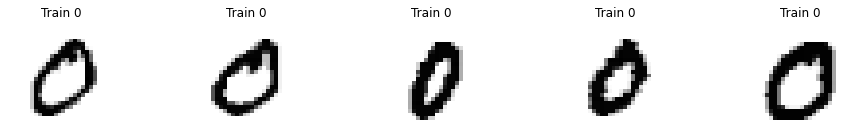

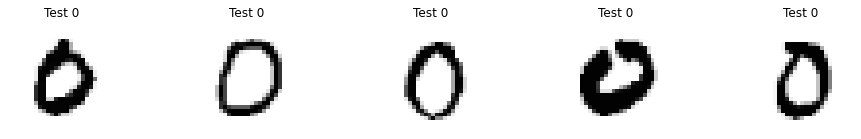

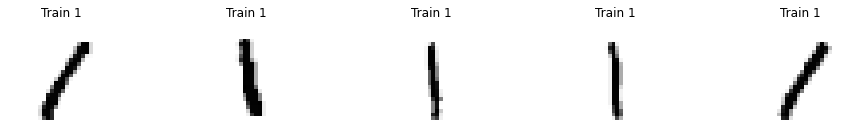

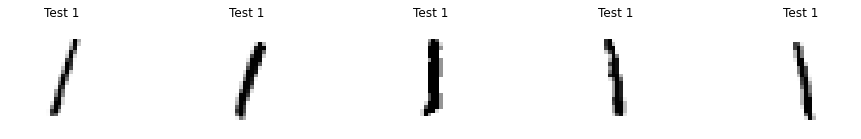

In [4]:
dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin = buildDataSet()
print("Checking shapes for class 0 (train) : ",dataset_train[0].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[0].shape)
print("Checking first samples")
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)

#3. Define the Neural Network to Learn Image Similarity

In [5]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

In [6]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

#4. Define the Keras Model for Training

กำหนด margin = 0.2

In [7]:
def build_model(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [8]:
network = build_network(input_shape,embeddingsize=10)
network_train = build_model(input_shape,network)
optimizer = Adam(lr = 0.00006)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()
plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='02 model.png')
print(network_train.metrics_names)
n_iteration=0
#network_train.load_weights('mnist-160k_weights.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 positive_input (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 negative_input (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 10)           4688522     ['anchor_input[0][0]',           
                                                                  'positive_input[0][0]',     

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[]


In [9]:
#testing our NN with dummy image
featured_img = network.predict(np.ones((1,img_rows,img_cols,1)))
print(featured_img)

1/1 [==============================] - 0s 498ms/step
[[-0.16095537 -0.12213531 -0.03782108  0.18669161 -0.02923309 -0.2623363
  -0.1956742   0.4212532  -0.7687335   0.2156929 ]]


#5. Define Batch

In [10]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets

In [11]:
def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])

In [12]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

In [13]:
def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network,s="train"):
    """
    Create batch of APN "hard" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size,s)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection,:,:,:], studybatch[1][selection,:,:,:], studybatch[2][selection,:,:,:]]
    
    return triplets

Checking batch width, should be 3 :  3
Shapes in the batch A:(2, 28, 28, 1) P:(2, 28, 28, 1) N:(2, 28, 28, 1)


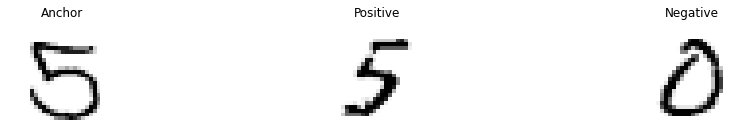

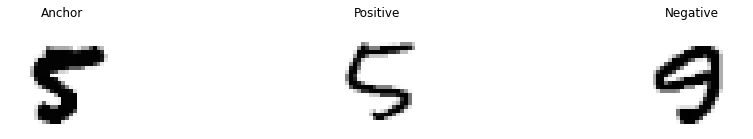

In [14]:
triplets = get_batch_random(2)
print("Checking batch width, should be 3 : ",len(triplets))
print("Shapes in the batch A:{0} P:{1} N:{2}".format(triplets[0].shape, triplets[1].shape, triplets[2].shape))
drawTriplets(triplets)

2/2 [==============================] - 0s 44ms/step
Shapes in the hardbatch A:(2, 28, 28, 1) P:(2, 28, 28, 1) N:(2, 28, 28, 1)


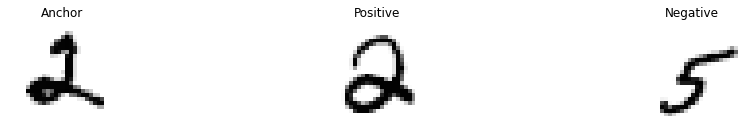

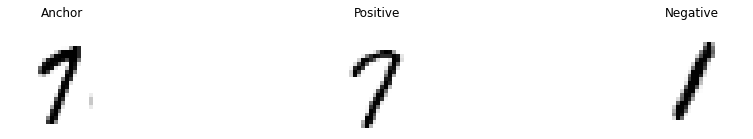

In [15]:
hardtriplets = get_batch_hard(50,1,1,network)
print("Shapes in the hardbatch A:{0} P:{1} N:{2}".format(hardtriplets[0].shape, hardtriplets[1].shape, hardtriplets[2].shape))
drawTriplets(hardtriplets)

#6. def for Model

In [17]:
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

In [18]:
def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

In [19]:
def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,img_rows,img_cols,1))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

In [20]:
def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()

In [21]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx

In [22]:
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

In [23]:
def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
                    
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

#7. Define Parameters

In [24]:
# Hyper parameters
evaluate_every = 1000 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 10 #80000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on

#8. Test (on untrained network)

16/16 [==============================] - 1s 64ms/step


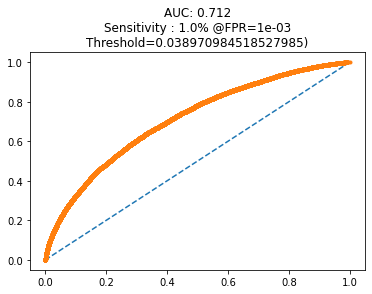

1/1 [==============================] - 0s 99ms/step


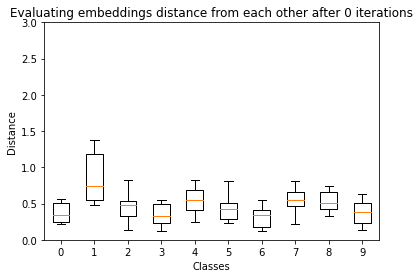

In [29]:
#Testing on an untrained network
probs,yprob = compute_probs(network,x_test_origin[:500,:,:,:],y_test_origin[:500])
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(network,n_iteration)

1/1 [==============================] - 0s 50ms/step


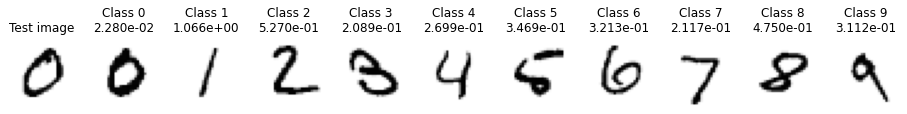

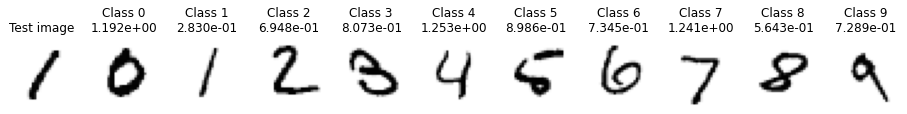

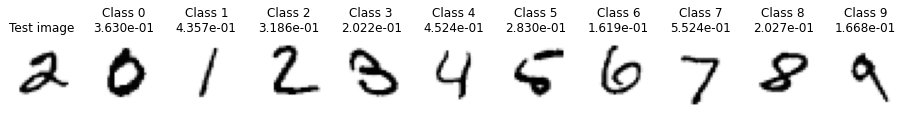

In [30]:
for i in range(3):
    DrawTestImage(network,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))

#9. Test (on trained network)

In [31]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
for i in range(1, n_iter+1):
    triplets = get_batch_hard(200,16,16,network)
    loss = network_train.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        probs,yprob = compute_probs(network,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr)

Starting training process!
-------------------------------------
7/7 [==============================] - 0s 37ms/step


313/313 [==============================] - 10s 33ms/step


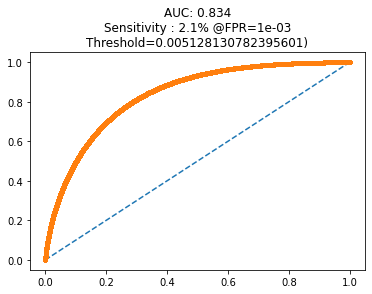

1/1 [==============================] - 0s 55ms/step


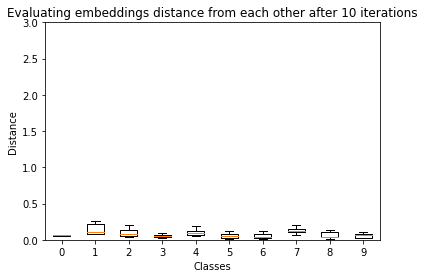

In [33]:
#Full evaluation
probs,yprob = compute_probs(network,x_test_origin,y_test_origin)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(network,n_iteration)

1/1 [==============================] - 0s 37ms/step


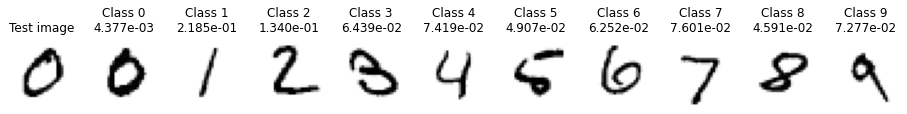

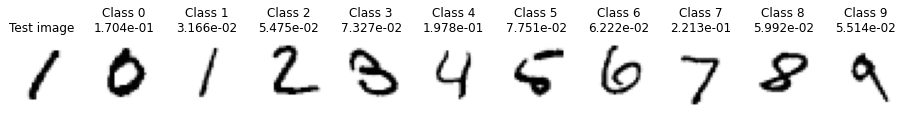

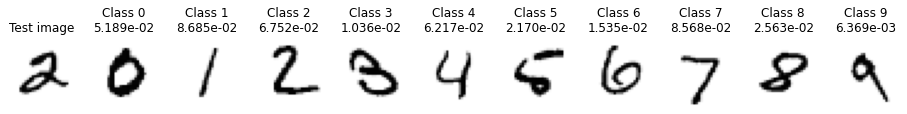

In [32]:
for i in range(3):
    DrawTestImage(network,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))

***